![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Classification using CNN: CIFAR10
- **Images**: 60,000 color images of size **(32x32)** in **10 categories**, with 6000 images per class. There are 50000 training images and 10000 test images.
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **Shape**: `(batch_size, 3, 32, 32)` → 3 channels (RGB).
  
![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


## 1️⃣ Dataset Class

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)#shuffle in training only, workers mean use 2 inner CPUs to send image from data to GPU
#if we gor an error:(Cuda out of memory), this means lower your batch size
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000, Testing samples: 10000


In [ ]:
train_dataset[0] #take the index shows a tensor(single image) then a number alone at the end, this number(here is 6) is the lable of that tensor

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [ ]:
train_dataset #to see the data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Let's display some images

In [ ]:
'''
handling the images is different:
Torch -> (Batch_size, channels, height, width)
Numpy, Matplotlib -> (Batch_size, height, width, Channels)
'''
#so we need Permute function to reorder Torch in the way that Tensor deal with it:
permute(0,2,3,1)# -->Tensor in torch #batch remains, then bring the height and width , then put the channels at the end
transpose(0,2,3,1)# -->in Numpy

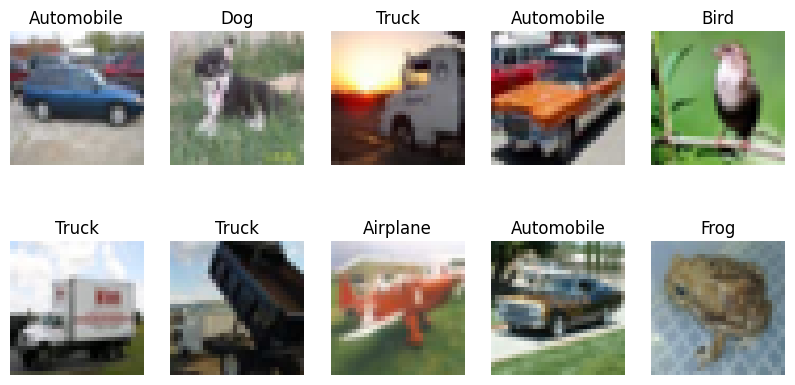

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data,,, this is another way instead of taking an index of a train_data
data_iter = iter(train_loader)# put the data in iteration like tuples with labels
images, labels = next(data_iter)#take the first sample(which our batch is 32 so 32 images will take in display)

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W)torch to (H, W, C)numpys
#either transform it to transoose with numby or use Permute with torch
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.show()

In [ ]:
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 32, 32)

Shape of one image tensor: torch.Size([3, 32, 32])


## 2️⃣ Model Class

In [ ]:
import torch.nn as nn
import torch

# Define the CNN Model FROM SCRATCH
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)#64 is # of channels, 4*4 is the image output size (formula)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.relu(self.conv2(x)))  # (Batch, 32, 8, 8)
        x = self.pool(self.relu(self.conv3(x)))  # (Batch, 64, 4, 4)

        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)
        #print(x.shape) in order to find the shape and paass into self.fc1 = nn.Linear(64 * 4 * 4, 128) instead of 64*4*4

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits
        #there is no need of softmax because in training loop we will use CrossEntropyLoss for multi-class classification, and it has softmax inernallly

        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)

In [ ]:
Previous code is on custom or random model, next is on AlexNet.

In [ ]:
class AlexNet32(nn.Module): #IMPORTANT#########
    def __init__(self, num_classes=10):
        super(AlexNet32, self).__init__()
        self.features = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=5),  # Output: 96 x 16 x 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 96 x 7 x 7

            nn.Conv2d(96, 256, kernel_size=5, padding=2),          # Output: 256 x 7 x 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 256 x 3 x 3

            nn.Conv2d(256, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),         # Output: 256 x 3 x 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)                   # Output: 256 x 2 x 2
        )

        self.classifier = nn.Sequential(
            nn.Dropout(), #check what is doing in detailes, you can use it in conv. default is 0.5
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),# inplace take the position of the assign it, check it.
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 3️⃣ Training and Validation Loops

In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):#tqdm is package like a progress bar
        images, labels = images.to(device), labels.to(device)#to GPU


        outputs = model(images)  # Forward , pass the images to the model
        loss = criterion(outputs, labels)  # Compute loss

        #update the weights:
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy, must be in probability not in logits as CrossEnropyLoss
        outputs = torch.softmax(outputs, dim=1)#WHY? when we use any matric outside the CrossEntropyLoss we should use Softmax
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()
#there is no weight updating in validation loop..

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1) #WHY? reason above
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


## 4️⃣ Running Training

In [ ]:
import torch.optim as optim

# Initialize the  as object not class as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:05<00:00, 278.70it/s]


Epoch 1/10: Train Loss=1.5622, Train Accuracy=42.92%, Val Loss=1.3153, Val Accuracy=51.55%


100%|██████████| 1563/1563 [00:05<00:00, 311.67it/s]


Epoch 2/10: Train Loss=1.1943, Train Accuracy=57.12%, Val Loss=1.0707, Val Accuracy=62.22%


100%|██████████| 1563/1563 [00:04<00:00, 328.35it/s]


Epoch 3/10: Train Loss=1.0130, Train Accuracy=64.09%, Val Loss=0.9853, Val Accuracy=65.35%


100%|██████████| 1563/1563 [00:05<00:00, 300.98it/s]


Epoch 4/10: Train Loss=0.9028, Train Accuracy=68.06%, Val Loss=0.9494, Val Accuracy=66.63%


100%|██████████| 1563/1563 [00:05<00:00, 287.02it/s]


Epoch 5/10: Train Loss=0.8263, Train Accuracy=70.89%, Val Loss=0.8877, Val Accuracy=68.94%


100%|██████████| 1563/1563 [00:04<00:00, 322.82it/s]


Epoch 6/10: Train Loss=0.7673, Train Accuracy=73.02%, Val Loss=0.8543, Val Accuracy=70.65%


100%|██████████| 1563/1563 [00:04<00:00, 341.47it/s]


Epoch 7/10: Train Loss=0.7122, Train Accuracy=74.95%, Val Loss=0.8653, Val Accuracy=69.99%


100%|██████████| 1563/1563 [00:04<00:00, 321.74it/s]


Epoch 8/10: Train Loss=0.6633, Train Accuracy=76.74%, Val Loss=0.8716, Val Accuracy=70.02%


100%|██████████| 1563/1563 [00:04<00:00, 339.87it/s]


Epoch 9/10: Train Loss=0.6223, Train Accuracy=77.96%, Val Loss=0.8544, Val Accuracy=71.69%


100%|██████████| 1563/1563 [00:04<00:00, 325.72it/s]


Epoch 10/10: Train Loss=0.5836, Train Accuracy=79.53%, Val Loss=0.9040, Val Accuracy=70.34%


### Plot loss and some predictions

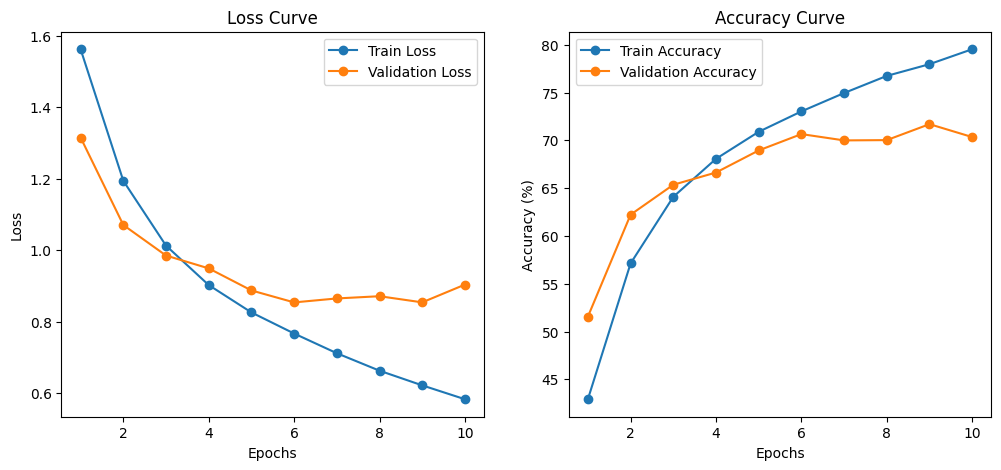

In [ ]:
import matplotlib.pyplot as plt
## SHOW LOSS
# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


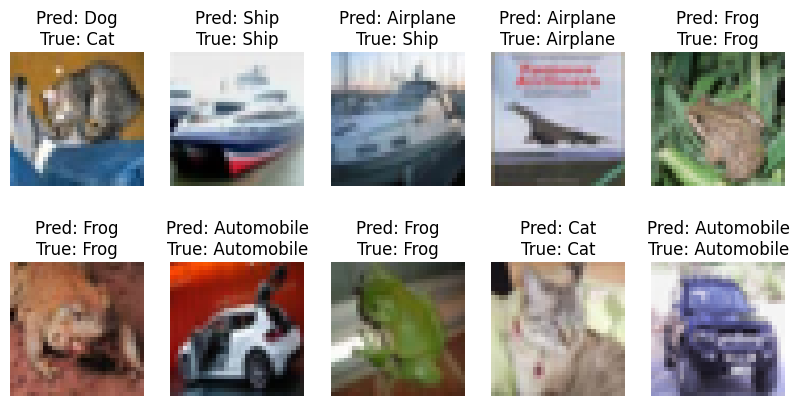

In [ ]:
import numpy as np
#SHOW PREDICTIONS
# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    # CIFAR-10 class names
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C), Must be plot in CPU

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, test_loader, device)


## 4️⃣ Running Training On AlexNet


In [ ]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelAlex = AlexNet32(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(modelAlex.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(modelAlex, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(modelAlex, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:10<00:00, 151.79it/s]


Epoch 1/10: Train Loss=1.7728, Train Accuracy=31.96%, Val Loss=1.4649, Val Accuracy=45.20%


100%|██████████| 1563/1563 [00:10<00:00, 150.64it/s]


Epoch 2/10: Train Loss=1.4235, Train Accuracy=47.96%, Val Loss=1.2504, Val Accuracy=55.13%


100%|██████████| 1563/1563 [00:10<00:00, 150.56it/s]


Epoch 3/10: Train Loss=1.2623, Train Accuracy=54.71%, Val Loss=1.1504, Val Accuracy=59.15%


100%|██████████| 1563/1563 [00:10<00:00, 148.56it/s]


Epoch 4/10: Train Loss=1.1478, Train Accuracy=59.26%, Val Loss=1.0357, Val Accuracy=63.89%


100%|██████████| 1563/1563 [00:10<00:00, 151.19it/s]


Epoch 5/10: Train Loss=1.0605, Train Accuracy=62.67%, Val Loss=1.0885, Val Accuracy=62.32%


100%|██████████| 1563/1563 [00:10<00:00, 150.11it/s]


Epoch 6/10: Train Loss=0.9964, Train Accuracy=65.21%, Val Loss=1.0017, Val Accuracy=65.44%


100%|██████████| 1563/1563 [00:10<00:00, 155.89it/s]


Epoch 7/10: Train Loss=0.9401, Train Accuracy=67.36%, Val Loss=0.9558, Val Accuracy=66.88%


100%|██████████| 1563/1563 [00:10<00:00, 156.06it/s]


Epoch 8/10: Train Loss=0.8992, Train Accuracy=69.02%, Val Loss=0.9781, Val Accuracy=66.44%


100%|██████████| 1563/1563 [00:10<00:00, 145.91it/s]


Epoch 9/10: Train Loss=0.8567, Train Accuracy=70.64%, Val Loss=0.9006, Val Accuracy=69.60%


100%|██████████| 1563/1563 [00:09<00:00, 157.01it/s]


Epoch 10/10: Train Loss=0.8235, Train Accuracy=71.64%, Val Loss=0.9294, Val Accuracy=69.01%


### Plot loss and some predictions

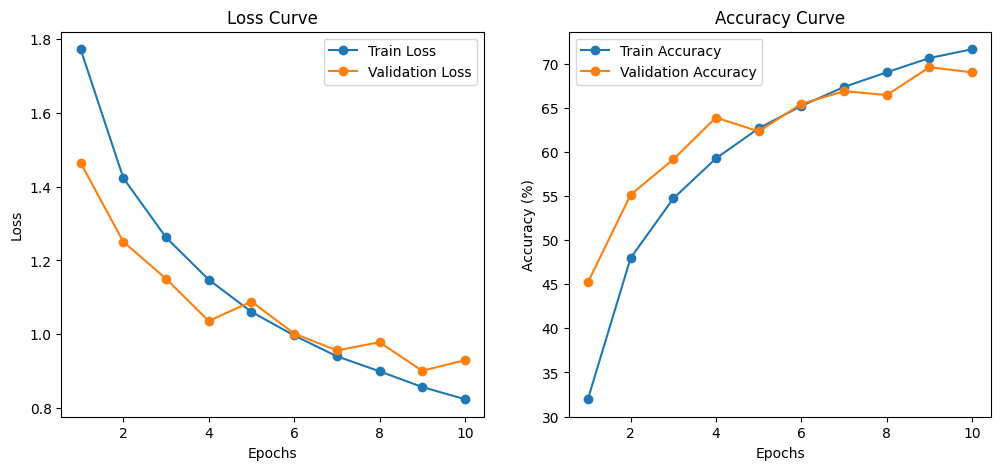

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


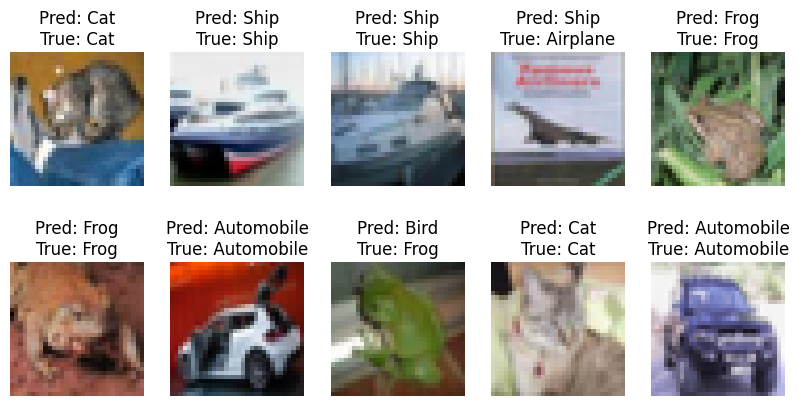

In [ ]:
# Show predictions
show_predictions(modelAlex, test_loader, device)


### Contributed by: Mohamed Eltayeb & Ali Habibullah

![image.png](https://i.imgur.com/a3uAqnb.png)